<a href="https://colab.research.google.com/github/msc-acse/acse-9-independent-research-project-Garethlomax/blob/full_data_run/Model_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook for testing and visualising the trained models, instead of just editing in and out of the other note books. 


# IMPORTS


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:

%cd /content/drive/My \Drive/masters_project/python_modules/MovingMNIST-master

# all torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import h5py

# importing moving mnist test set.
from MovingMNIST import MovingMNIST

%cd /content/drive/My \Drive/masters_project/python_modules/pytorch-summary-master
from torchsummary import summary

# %cd /content/drive/My \Drive/masters_project/python_modules/pytorch_modelsize-master

%cd /content/drive/My \Drive/masters_project/python_modules/pytorchvis-master

!pip install torchviz

%cd /content/drive/My\ Drive/masters_project/python_modules/pytorch-ssim-master
import pytorch_ssim # cite this 


torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True



/content/drive/My Drive/masters_project/python_modules/MovingMNIST-master
/content/drive/My Drive/masters_project/python_modules/pytorch-summary-master
[Errno 2] No such file or directory: '/content/drive/My Drive/masters_project/python_modules/pytorchvis-master'
/content/drive/My Drive/masters_project/python_modules/pytorch-summary-master
     |████████████████████████████████| 51kB 11.8MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=df46cb66d39b1f52f6c18b51a05ac02da880fbd5b3548f5b7ca9fd96f889d970
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
/content/drive/My Drive/masters_project/python_modules/pytorch-ssim-master


In [0]:
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
import pandas as pd

In [4]:
h5py.run_tests()

.....................................................x...................................................................x....................................s...s......ss.......................................................................................................ssssss...................................................................x....x.........................x......x.................................................ssss..................
----------------------------------------------------------------------
Ran 457 tests in 0.873s

OK (skipped=14, expected failures=6)


<unittest.runner.TextTestResult run=457 errors=0 failures=0>

## cuda imports

In [5]:

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    print("GPUs:", torch.cuda.device_count())
    device = 'cuda'
else:
    print("No GPU available!")
    
    
import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True
  
set_seed(42)




Cuda installed! Running on GPU!
GPUs: 1


True

# LSTM CODE

## LSTM CELL

In [0]:
"""TODO: CUDIFY EVERYTHING"""





class LSTMunit(nn.Module):
    def __init__(self, input_channel_no, hidden_channels_no, kernel_size, stride = 1):
        super(LSTMunit, self).__init__()
        """base unit for an overall convLSTM structure. convLSTM exists in keras but
        not pytorch. LSTMunit repersents one cell in an overall convLSTM encoder decoder format
        the structure of convLSTMs lend themselves well to compartmentalising the LSTM
        cells. 
    
        Each cell takes an input the data at the current timestep Xt, and a hidden
        representation from the previous timestep Ht-1
    
        Each cell outputs Ht
        """
    
    
        self.input_channels = input_channel_no
    
        self.output_channels = hidden_channels_no
    
        self.kernel_size = kernel_size
    
        self.padding = (int((self.kernel_size - 1) / 2 ), int((self.kernel_size - 1) / 2 ))#to ensure output image same dims as input
        # as in conv nowcasting - see references 
        self.stride = stride # for same reasons as above
        
        # need convolutions, cells, tanh, sigmoid?
        # need input size for the lstm - on size of layers.
        # cannot do this because of the modules not being registered when stored in a list
        # can if we convert it to a parameter dict
    
        # list of names of filter to put in dictionary.
        # some of these are not convolutions
        """TODO: CHANGE THIS LAYOUT OF CONVOLUTIONAL LAYERS. """
        
        
        
        self.filter_name_list = ['Wxi', 'Wxf', 'Wxc', 'Wxo','Whi', 'Whf', 'Whc', 'Who']
        
        """ TODO : DEAL WITH BIAS HERE. """ 
        """ TODO: CAN INCLUDE BIAS IN ONE OF THE CONVOLUTIONS BUT NOT ALL OF THEM - OR COULD INCLUDE IN ALL? """

        # list of concolution instances for each lstm cell step
       #  nn.Conv2d(1, 48, kernel_size=3, stride=1, padding=0),
        self.conv_list = [nn.Conv2d(self.input_channels, self.output_channels, kernel_size =  self.kernel_size, stride = self.stride, padding = self.padding, bias = False).cuda() for i in range(4)]
#         self.conv_list = [nn.Conv2d(self.input_channels, self.output_channels, kernel_size =  self.kernel_size, stride = self.stride, padding = self.padding, bias = False) for i in range(4)]

#         self.conv_list = self.conv_list + [(nn.Conv2d(self.output_channels, self.output_channels, kernel_size =  self.kernel_size, stride = self.stride, padding = self.padding, bias = True)).double() for i in range(4)]

        self.conv_list = self.conv_list + [(nn.Conv2d(self.output_channels, self.output_channels, kernel_size =  self.kernel_size, stride = self.stride, padding = self.padding, bias = True).cuda()).double() for i in range(4)]
#         self.conv_list = nn.ModuleList(self.conv_list)
        # stores nicely in dictionary for compact readability.
        # most ML code is uncommented and utterly unreadable. Here we try to avoid this
        self.conv_dict = nn.ModuleDict(zip(self.filter_name_list, self.conv_list))
    
        # may be able to combine all the filters and combine all the things to be convolved - as long as there is no cross layer convolution
        # technically the filter will be the same? - check this later.
    
        # set up W_co, W_cf, W_co as variables.
        """ TODO: decide whether this should be put into function. """
        
        
        """TODO: put correct dimensions of tensor in shape"""
        
        # of dimensions seq length, hidden layers, height, width
        """TODO: DEFINE THESE SYMBOLS. """
        """TODO: PUT THIS IN CONSTRUCTOR."""
        shape = [1, self.output_channels, 16, 16]
        
        self.Wco = nn.Parameter((torch.zeros(shape).double()).cuda(), requires_grad = True)
        self.Wcf = nn.Parameter((torch.zeros(shape).double()).cuda(), requires_grad = True)
        self.Wci = nn.Parameter((torch.zeros(shape).double()).cuda(), requires_grad = True)
        
        
#         self.Wco = nn.Parameter((torch.zeros(shape).double()), requires_grad = True)
#         self.Wcf = nn.Parameter((torch.zeros(shape).double()), requires_grad = True)
#         self.Wci = nn.Parameter((torch.zeros(shape).double()), requires_grad = True)
#         self.Wco.name = "test"
#         self.Wco = torch.zeros(shape, requires_grad = True).double()
#         self.Wcf = torch.zeros(shape, requires_grad = True).double()
#         self.Wci = torch.zeros(shape, requires_grad = True).double()

        # activation functions.
        self.tanh = torch.tanh
        self.sig  = torch.sigmoid

#     (1, 6, kernel_size=5, padding=2, stride=1).double()
    def forward(self, x, h, c):
        """ put the various nets in here - instanciate the other convolutions."""
        """TODO: SORT BIAS OUT HERE"""
        """TODO: PUT THIS IN SELECTOR FUNCTION? SO ONLY PUT IN WXI ECT TO MAKE EASIER TO DEBUG?"""
#         print("size of x is:")
#         print(x.shape)
        # ERROR IS IN LINE 20
        #print(self.conv_dict['Wxi'](x).shape)
#         print("X:")
#         print(x.is_cuda)
#         print("H:")
#         print(h.is_cuda)
#         print("C")
#         print(c.is_cuda)
        
        i_t = self.sig(self.conv_dict['Wxi'](x) + self.conv_dict['Whi'](h) + self.Wci * c)
        f_t = self.sig(self.conv_dict['Wxf'](x) + self.conv_dict['Whf'](h) + self.Wcf * c)
        c_t = f_t * c + i_t * self.tanh(self.conv_dict['Wxc'](x) + self.conv_dict['Whc'](h))
        o_t = self.sig(self.conv_dict['Wxo'](x) + self.conv_dict['Who'](h) + self.Wco * c_t)
        h_t = o_t * self.tanh(c_t)
        
        return h_t, c_t
    
    def copy_in(self):
        """dummy function to copy in the internals of the output in the various architectures i.e encoder decoder format"""

## LSTM Full Unit

In [0]:
"""TODO: IMPORTANT 
WHEN COPYING STATES OVER, INITIAL STATE OF DECODER IS BOTH LAST H AND LAST C 
FROM THE LSTM BEING COPIED FROM.

WE ALSO NEED TO INCLUDE THE ABILITY TO OUTPUT THE LAST H AND C AT EACH TIMESTEP
AS INPUT.
"""


""" SEQUENCE, BATCH SIZE, LAYERS, HEIGHT, WIDTH"""

class LSTMmain(nn.Module):
    
    
    """ collection of units to form encoder/ decoder branches - decide which are which
    need funcitonality to copy in and copy out outputs.
    
    
    layer output is array of booleans selectively outputing for each layer i.e 
    for three layer can have output on second and third but not first with 
    layer_output = [0,1,1]"""
    
    """TODO: DECIDE ON OUTPUT OF HIDDEN CHANNEL LIST """
    def __init__(self, shape, input_channel_no, hidden_channel_no, kernel_size, layer_output, test_input, copy_bool = False, debug = False, save_outputs = True, decoder = False, second_debug = False):
        super(LSTMmain, self).__init__()
        
        """TODO: USE THIS AS BASIS FOR ENCODER DECODER."""
        """TODO: SPECIFY SHAPE OF INPUT VECTOR"""
        
        """TODO: FIGURE OUT HOW TO IMPLEMENT ENCODER DECODER ARCHITECUTRE"""
        self.copy_bool = copy_bool
        
        self.test_input = test_input
        
        self.debug = debug
        self.second_debug = second_debug
        self.save_all_outputs = save_outputs
        
        self.shape = shape
        
        """specify dimensions of shape - as in channel length ect. figure out once put it in a dataloader"""
        
        self.layers = len(test_input) #number of layers in the encoder. 
        
        self.seq_length = shape[1]
        
        self.enc_len = len(shape)
        
        self.input_chans = input_channel_no
        
        self.hidden_chans = hidden_channel_no
        
        self.kernel_size = kernel_size
        
        self.layer_output = layer_output
        
        # initialise the different conv cells. 
#         self.unit_list = [LSTMunit(input_channel_no, hidden_channel_no, kernel_size) for i in range(self.enc_len)]
        self.dummy_list = [input_channel_no] + list(self.test_input) # allows test input to be an array
        if self.debug:
            print("dummy_list:")
            print(self.dummy_list)
            
#         self.unit_list = nn.ModuleList([(LSTMunit(self.dummy_list[i], self.dummy_list[i+1], kernel_size).double()).cuda() for i in range(len(self.test_input))])
        self.unit_list = nn.ModuleList([(LSTMunit(self.dummy_list[i], self.dummy_list[i+1], kernel_size).double()).cuda() for i in range(len(self.test_input))])
        
        if self.debug:
            print("number of units:")
            print(len(self.unit_list))
#             print("number of ")

#         self.unit_list = nn.ModuleList(self.unit_list)
    
    
    def forward(self, x, copy_in = False, copy_out = [False, False, False]):
#     def forward(self, x):
#         copy_in = False
#         copy_out = [False, False, False]

        
#         print("IS X CUDA?")
#         print(x.is_cuda)
        """loop over layers, then over hidden states
        
        copy_in is either False or is [[h,c],[h,c]] ect.
        
        THIS IN NOW CHANGED TO COPY IN 
        
        """
        
        internal_outputs = []
        """TODO: HOW MANY OUTPUTS TO SAVE"""
        """ S """
        
        """ TODO: PUT INITIAL ZERO THROUGH THE SYSTEM TO DEFINE H AND C"""
        
        layer_output = [] # empty list to save each h and c for each step. 
        """TODO: DECIDE WHETHER THE ABOVE SHOULD BE ARRAY OR NOT"""
        
        # x is 5th dimensional tensor.
        # x is of size batch, sequence, layers, height, width
        
        """TODO: INITIALISE THESE WITH VECTORS."""
        # these need to be of dimensions (batchsizze, hidden_dim, heigh, width)
        
        size = x.shape
        
        # need to re arrange the outputs. 
        
        
        """TODO: SORT OUT H SIZING. """
        
        batch_size = size[0]
        # change this. h should be of dimensions hidden size, hidden size.
        h_shape = list(x.shape[:1] + x.shape[2:]) # seq is second, we miss it with fancy indexing
        h_shape[1] = self.hidden_chans
        if self.debug:
            print("h_shape:")
            print(h_shape)
        
        # size should be (seq, batch_size, layers, height, weight)
        
        
        empty_start_vectors = []
        
        
        #### new method of copying vectors. copy_bool, assigned during object 
        # construction now deals iwth copying in values.
        # copy in is still used to supply the tensor values. 
    
        k = 0 # to count through our input state list.
        for i in range(self.layers):
            if self.copy_bool[i]: # if copy bool is true for this layer
                # check purpose of h_shape in below code.
                empty_start_vectors.append(copy_in[k])
                # copies in state for that layer
                """TODO: CHECK IF THIS NEEDS TO BE DETATCHED OR NOT"""
                k += 1 # iterate through input list.
            
            else: # i.e if false
                assert self.copy_bool[i] == False, "copy_bool arent bools"
                
                h_shape = list(x.shape[:1] + x.shape[2:]) # seq is second, we miss it with fancy indexing
                h_shape[1] = self.dummy_list[i+1] # check indexing. 
                empty_start_vectors.append([(torch.zeros(h_shape).double()).cuda(), (torch.zeros(h_shape).double()).cuda()])
                
        del k # clear up k so no spare variables flying about.
        
        
        
        
#         for i in range(self.layers):
#             """CHANGED: NOW HAS COPY IN COPY OUT BASED ON [[0,0][H,C]] FORMAT"""
#             if copy_in == False: # i.e if no copying in occurs then proceed as normal
#                 h_shape = list(x.shape[:1] + x.shape[2:]) # seq is second, we miss it with fancy indexing
#                 h_shape[1] = self.dummy_list[i+1] # check indexing. 
# #                 empty_start_vectors.append([(torch.zeros(h_shape).double()).cuda(), (torch.zeros(h_shape).double()).cuda()])
#                 empty_start_vectors.append([(torch.zeros(h_shape).double()).cuda(), (torch.zeros(h_shape).double()).cuda()])
# #             elif copy_in[i] == [0,0]:
#             elif isinstance(copy_in[i], list):

#                 assert (len(copy_in) == self.layers), "Length disparity between layers, copy in format"

#                 # if no copying in in alternate format
#                 h_shape = list(x.shape[:1] + x.shape[2:]) # seq is second, we miss it with fancy indexing
#                 h_shape[1] = self.dummy_list[i+1] # check indexing. 
#                 empty_start_vectors.append([(torch.zeros(h_shape).double()).cuda(), (torch.zeros(h_shape).double()).cuda()])
                
#             else: # copy in the provided vectors
#                 assert (len(copy_in) == self.layers), "Length disparity between layers, copy in format"

#                 """TODO: DECIDE WHETHER TO CHANGE THIS TO AN ASSERT BASED OFF TYPE OF TENSOR."""
#                 empty_start_vectors.append(copy_in[i])
                
            
        
        
        
#         empty_start_vectors = [[torch.zeros(h_shape), torch.zeros(h_shape)] for i in range(self.layers)]
        
        
        
        if self.debug:
            for i in empty_start_vectors:
                print(i[0].shape)
            print(" \n \n \n")
        
#         for i in range(self.layers):
#             empty_start_vectors.append([torch.tensor()])
        
        total_outputs = []
        
        
        for i in range(self.layers):
            
            
            layer_output = []
            if self.debug:
                print("layer iteration:")
                print(i)
            # for each in layer

            """AS WE PUT IN ZEROS EACH TIME THIS MAKES OUR LSTM STATELESS"""
            # initialise with zero or noisy vectors 
            # at start of each layer put noisy vector in 
            # look at tricks paper to find more effective ideas of how to put this in
            # do we have to initialise with 0 tensors after we go to the second layer
            # or does the h carry over???
            """TODO: REVIEW THIS CHANGE"""
            
            # copy in for each layer. 
            # this is used for encoder decoder architectures.
            # default is to put in empty vectors. 
            
            """TODO: REVIEW THIS SECTION"""
            """CHANGED: TO ALWAYS CHOOSE H AND C"""
#             if copy_in == False:
#                 h, c = empty_start_vectors[i]
#             else: h, c = copy_in[i]

            h, c = empty_start_vectors[i] 
                
            if self.debug:
                print("new h shape")
                print(h.shape)
                
            """TODO: DO WE HAVE TO PUT BLANK VECTORS IN AT EACH TIMESTEP?"""
            
            # need to initialise zero states for c and h. 
            for j in range(self.seq_length):
                if self.debug:
                    print("inner loop iteration:")
                    print(j)
                if self.debug:
                    print("x dtype is:" , x.dtype)
                # for each step in the sequence
                # put x through 
                # i.e put through each x value at a given time.
                
                """TODO: PUT H IN FROM PREVIOUS LAYER, BUT C SHOULD BE ZEROS AT START"""
                
                if self.debug:
                    print("inner loop size:")
                    print(x[:,j].shape)
                    print("h size:")
                    print(h.shape)
                    
                h, c = self.unit_list[i](x[:,j], h, c)
                
                # this is record for each output in given layer.
                # this depends whether copying out it enabld 
#                 i
                layer_output.append([h, c])
                
            """TODO: IMPLEMENT THIS"""
#             if self.save_all_outputs[i]:
#                 total_outputs.append(layer_outputs[:,0]) # saves h from each of the layer outputs
                
            # output 
            """OUTSIDE OF SEQ LOOP"""
            """TODO: CHANGE TO NEW OUTPUT METHOD."""
            if copy_out[i] == True:
                # if we want to copy out the contents of this layer:
                internal_outputs.append(layer_output[-1])
                # saves last state and memory which can be subsequently unrolled.
                # when used in an encoder decoder format.
            """removed else statement"""
#             else:
#                 internal_outputs.append([0,0])
                # saves null variable so we can check whats being sent out.
            
            
            h_output = [i[0] for i in layer_output] #layer_output[:,0] # take h from each timestep.
            if self.debug:
                print("h_output is of size:")
                print(h_output[0].shape)
                
                      
            """TODO: REVIEW IF 1 IS THE CORRECT AXIS TO CONCATENATE THE VECTORS ALONG"""
            # we now use h as the predictor input to the other layers.
            """TODO: STACK TENSORS ALONG NEW AXIS. """
            
            
            x = torch.stack(h_output,0)
            x = torch.transpose(x, 0, 1)
            if self.second_debug:
                print("x shape in LSTM main:" , x.shape)
            if self.debug:
                print("x reshaped dimensions:")
                print(x.shape)
        
#         x = torch.zeros(x.shape)
#         x.requires_grad = True
        return x , internal_outputs # return new h in tensor form. do we need to cudify this stuff

    def initialise(self):
        """put through zeros to start everything"""
        

## lstm enc dec onestep

In [0]:
# test2 = LSTMmain(shape, 1, 3, 5, [1], test_input = [1,2], debug = False).double()



class LSTMencdec_onestep(nn.Module):
    """structure is overall architecture of """
    def __init__(self, structure, input_channels, kernel_size = 5, debug = True):
        super(LSTMencdec_onestep, self).__init__()
#         assert isinstance(structure, np.array), "structure should be a 2d numpy array"
        assert len(structure.shape) == 2, "structure should be a 2d numpy array with two rows"
        self.debug = debug
        
        """TODO: MAKE KERNEL SIZE A LIST SO CAN SPECIFY AT EACH JUNCTURE."""
        shape = [1,10,3,16,16]
        
        self.structure = structure
        """STRUCTURE IS AN ARRAY - CANNOT USE [] + [] LIST CONCATENATION - WAS ADDING ONE ONTO THE ARRAY THING."""
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        
        """TODO: ASSERT THAT DATATYPE IS INT."""
        
        self.enc_shape, self.dec_shape, self.enc_copy_out, self.dec_copy_in = self.input_test()
        
        if self.debug:
            print("enc_shape, dec_shape, enc_copy_out, dec_copy_in:")
            print(self.enc_shape)
            print(self.dec_shape)
            print(self.enc_copy_out)
            print(self.dec_copy_in)
            
        
        
#         self.sig = nn.Sigmoid()
        
         # why does this have +1 at third input and decoder hasnt?????? 
        
        self.encoder = LSTMmain(shape, self.input_channels, len(self.enc_shape)+1, self.kernel_size, layer_output = self.enc_copy_out, test_input = self.enc_shape, copy_bool = [False for k in range(len(self.enc_shape))]  ).cuda()
        # now one step in sequence
        shape = [1,1,1,64,64]

        self.decoder = LSTMmain(shape, self.enc_shape[-1], len(self.dec_shape), self.kernel_size, layer_output = 1, test_input = self.dec_shape, copy_bool = self.dec_copy_in,  second_debug = False).cuda()
        
        
        
        # initialise encoder and decoder network
    
    def input_test(self):
        """check input structure to make sure there is overlap between encoder 
        and decoder.
        """
        copy_grid = []
        # finds dimensions of the encoder
        enc_layer = self.structure[0]
        enc_shape = enc_layer[enc_layer!=0]
        dec_layer = self.structure[1]
        dec_shape = dec_layer[dec_layer!=0]
#         
        
        
        
        
        
        #set up boolean grid of where the overlaps are.
        for i in range(len(enc_layer)):
            if self.debug:
                print(enc_layer[i], dec_layer[i])
            if (enc_layer[i] != 0) and (dec_layer[i] != 0):
                copy_grid.append(True)
            else:
                copy_grid.append(False)
                
                
        enc_overlap = copy_grid[:len(enc_layer)-1]
        
        num_dec_zeros = len(dec_layer[dec_layer==0]) # will this break if no zeros?
        
        dec_overlap = copy_grid[num_dec_zeros:]
        
        return enc_shape, dec_shape, enc_overlap, dec_overlap
        
#         dec_overlap = copy_grid[]                
        
                
                
#         [[1,2,3,0],
#          [0,2,3,1]]
    def forward(self, x):
        
        x, out_states = self.encoder(x, copy_in = False, copy_out = self.enc_copy_out)
        
#         print("length of out_states:", len(out_states))
#         print("contents out outstates are as follows:")
#         for i in out_states:
#             print("----------------------------------")
#             print("first object type:", type(i[0]))
# #             print("length of object:", len(i[0]))
            
        
        
        
        dummy_input = torch.zeros(x.shape)
        # technically a conditional loader - put x in there 
        # puts in the last one as input - should make shorter. 
        # presume coming out in the correct order - next try reversing to see if that helps 
        x = x[:,-1:,:,:,:]
#         print("x shape encoder:", x.shape)
#         print(x.shape)
        
        
        res, _ = self.decoder(x, copy_in = out_states, copy_out = [False, False, False,False, False])
        print("FINISHING ONE PASS")
#         res = self.sig(res)
        return res

# dataset

In [0]:
class HDF5Dataset(Dataset):
    """dataset wrapper for hdf5 dataset to allow for lazy loading of data. This 
    allows ram to be conserved. 
    
    As the hdf5 dataset is not partitioned into test and validation, the dataset 
    takes a shuffled list of indices to allow specification of training and 
    validation sets.
    
    MAKE SURE TO CALL DEL ON GENERATED OBJECTS OTHERWISE WE WILL CLOG UP RAM
    
    """
    
    def __init__(self, path, index_map, transform = None):
        
        %cd /content/drive/My \Drive/masters_project/data 
        # changes directory to the one where needed.
        
        self.path = path
        
        self.index_map = index_map # maps to the index in the validation split
        # due to hdf5 lazy loading index map must be in ascending order.
        # this may be an issue as we should shuffle our dataset.
        # this will be raised as an issue as we consider a work around.
        # we should keep index map shuffled, and take the selection from the 
        # shuffled map and select in ascending order. 
        
        
        self.file = h5py.File(path, 'r')
        
        
        
        
        
        
    def __len__(self):
        return len(self.index_map)
    
    def __getitem__(self,i):
        
        i = self.index_map[i] # index maps from validation set to select new orders
#         print(i)
        if isinstance(i, list): # if i is a list. 
            i.sort() # sorts into ascending order as specified above
            
        """TODO: CHECK IF THIS RETURNS DOUBLE"""
        
        predictor = torch.tensor(self.file["predictor"][i])
        
        truth = torch.tensor(self.file["truth"][i])
        
        return predictor, truth

In [0]:
def initialise_dataset_HDF5(valid_frac = 0.1, dataset_length = 9000):
    """
    Returns datasets for training and validation. 
    
    Loads in datasets segmenting for validation fractions.
   
    
    
    """
    
    if valid_frac != 0:
        
        dummy = np.array(range(dataset_length)) # clean this up - not really needed
        
        train_index, valid_index = validation_split(dummy, n_splits = 1, valid_fraction = 0.1, random_state = 0)
        
        train_dataset = HDF5Dataset("train_set.hdf5", index_map = train_index)
        
        valid_dataset = HDF5Dataset("test_set.hdf5", index_map = valid_index)
        
        return train_dataset, valid_dataset
        
    else:
        print("not a valid fraction for validation") # turn this into an assert.
        
        
        

In [0]:
def initialise_dataset_HDF5_full(dataset, valid_frac = 0.1, dataset_length = 9000, avg = 0, std = 0, application_boolean = [0,0,0,0,0]):
    """
    Returns datasets for training and validation. 
    
    Loads in datasets segmenting for validation fractions.
   
    
    
    """
    
    if valid_frac != 0:
        
        dummy = np.array(range(dataset_length)) # clean this up - not really needed
        
        train_index, valid_index = validation_split(dummy, n_splits = 1, valid_fraction = 0.1, random_state = 0)
        
        train_index = list(train_index)
        
        valid_index = list(valid_index)
        
        train_dataset = HDF5Dataset_with_avgs(dataset,train_index, avg, std, application_boolean)
        
        valid_dataset = HDF5Dataset_with_avgs(dataset,valid_index, avg, std, application_boolean)
        
        
        return train_dataset, valid_dataset
        
    else:
        print("not a valid fraction for validation") # turn this into an assert.
        

# shuffling functions 

In [0]:
def validation_split(data, n_splits = 1, valid_fraction = 0.1, random_state = 0):
    """
    Function to produce a validation set from test set.
    THIS SHUFFLES THE SAMPLES. __NOT__ THE SEQUENCES.
    """
    dummy_array = np.zeros(len(data))
    split = StratifiedShuffleSplit(n_splits, test_size = valid_fraction, random_state = 0)
    generator = split.split(torch.tensor(dummy_array), torch.tensor(dummy_array))
    return [(a,b) for a, b in generator][0]

In [0]:
def unsqueeze_data(data):
    """
    Takes in moving MNIST object - must then account for 
    """
    
    # split moving mnist data into predictor and ground truth.
    predictor = data[:][0].unsqueeze(2)
    predictor = predictor.double()
        
    truth = data[:][1].unsqueeze(2)# this should be the moving mnist sent in
    truth = truth.double()
    
    return predictor, truth
    # the data should now be unsqueezed.

In [0]:
def initialise_dataset(data):
    # unsqueeze data, adding a channel dimension for later convolution. 
    # this also gets rid of the annoying tuple format
    predictor, truth = unsqueeze_data(data)
    
    train_index, valid_index = validation_split(data)
    
    train_predictor = predictor[train_index]
    valid_predictor = predictor[valid_index]
    
    train_truth = truth[train_index]
    valid_truth = truth[valid_index]
    
    train_dataset = SequenceDataset(train_predictor, train_truth)
    valid_dataset = SequenceDataset(valid_predictor, valid_truth)
    
    return train_dataset, valid_dataset

# training functions 


In [0]:
def comb_loss_func(pred, y):
    """hopefully should work like kl and bce for VAE"""
    mse = nn.MSELoss()
    ssim = pytorch_ssim.SSIM()
    mse_loss = mse(pred, y[:,:1,:,:,:])
    ssim_loss = -ssim(pred[:,0,:,:,:], y[:,0,:,:,:])
    return mse_loss + ssim_loss

In [16]:
%cd /content/drive/My\ Drive/masters_project/data/models
def train_enc_dec(model, optimizer, dataloader, loss_func = nn.MSELoss()):
    """
    training function 
    
    by default mseloss
    
    could try brier score.
    
    """
    i = 0
    model.train() # enables training for model. 
    tot_loss = 0
    for x, y in dataloader:
#         print("training")
        x = x.to(device) # send to cuda.
        y = y.to(device)
        optimizer.zero_grad() # zeros saved gradients in the optimizer.
        # prevents multiple stacking of gradients
        # this is important to do before we evaluate the model as the 
        # model is currenly in model.train() mode
        
        prediction = model(x) #x should be properly formatted - of size
        """THIS DOESNT DEAL WITH SEQUENCE LENGTH VARIANCE OF PREDICTION OR Y"""
        
#         print("the size of prediction is:", prediction.shape)
        #last image sequence.
    
        """ACTUAL FUNCTION THATS BEEN COMMENTED OUT."""
#         loss = loss_func(prediction, y[:,:1,:,:,:])
        """CHANGED BECAUSE """
        print(prediction.shape)
        print(y.shape)
        loss = loss_func(prediction[:,0,0], y)
        

#         loss = comb_loss_func(prediction, y)
#         print(prediction.shape)
#         print(y[:,:1,:,:,:].shape)
        """commented out """
#         loss = - loss_func(prediction[:,0,:,:,:], y[:,0,:,:,:])
    
# ssim_out = -ssim_loss(train[0][0][-1:],  x[0])
# ssim_value = - ssim_out.data
    
    
        
        loss.backward() # differentiates to find minimum.
#         printm()

        ##

    # implement the interpreteable stuff here.
        # as it is very unlikely we predict every pixel correctly we will not 
        # use accuracy. 
        # technically this is a regression problem, not a classification.
        
        
        optimizer.step() # steps forward the optimizer.
        # uses loss.backward() to give gradient. 
        # loss is negative.
#         del x # make sure the garbage is collected.
#         del y
        """commented it out"""
        tot_loss += loss.item() # .data.item() 
        print("BATCH:")
        print(i)
        i += 1
#         if i == 20:
#             break
        print("MSE_LOSS:", tot_loss / i)
    return model, tot_loss / i # trainloss, trainaccuracy 

def validate(model, dataloader, loss_func = nn.MSELoss()):
    
    """as for train_enc_dec but without training - and acting upon validation
    data set
    """
    tot_loss = 0
    i = 0
    model.eval() # puts out of train mode so we do not mess up our gradients
    for x, y in dataloader:
        with torch.no_grad(): # no longer have to specify tensors 
            # as volatile = True. as of modern pytorch use torch.no_grad.
            
            x = x.to(device) # send to cuda. need to change = sign as to(device)
            y = y.to(device) # produces a copy on thd gpu not moves it. 
            prediction = model(x)
            
            loss = loss_func(prediction[:,0,0], y)
            
            tot_loss += loss.item()
            i += 1
            
            print("MSE_VALIDATION_LOSS:", tot_loss / i)
            
    
    
    return tot_loss / i # returns total loss averaged across the dataset. 







def train_main(model, params, train, valid, epochs = 30, batch_size = 1):
    # make sure model is ported to cuda
    # make sure seed has been specified if testing comparative approaches
    
#     if model.is_cuda == False:
#         model.to(device)
    
    # initialise optimizer on model parameters 
    # chann
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.005, amsgrad= True)
    loss_func = nn.MSELoss()
#     loss_func = nn.BCELoss()
#     loss_func = pytorch_ssim.SSIM()
    
    train_loader = DataLoader(train, batch_size = batch_size, shuffle = True) # implement moving MNIST data input
    validation_loader = DataLoader(valid, batch_size = batch_size, shuffle = False) # implement moving MNIST
    
    for epoch in range(epochs):
        
        train_enc_dec(model, optimizer, train_loader, loss_func = loss_func) # changed
        
        
        torch.save(optimizer.state_dict(), F"Adam_new_ams_changed"+str(epoch)+".pth")
        torch.save(model.state_dict(), F"Test_new_ams_changed"+str(epoch)+".pth")
        
        
#         validate(model, validation_loader)
        
    return model, optimizer
        
    
    
    
            
            
            
            
    


        
        
        
        
        
        
        
        
        
        
        
        

/content/drive/My Drive/masters_project/data/models


# hdf5 with avgs

In [0]:
class HDF5Dataset_with_avgs(Dataset):
    """dataset wrapper for hdf5 dataset to allow for lazy loading of data. This 
    allows ram to be conserved. 
    
    As the hdf5 dataset is not partitioned into test and validation, the dataset 
    takes a shuffled list of indices to allow specification of training and 
    validation sets.
    
    MAKE SURE TO CALL DEL ON GENERATED OBJECTS OTHERWISE WE WILL CLOG UP RAM
    
    """
    
    def __init__(self, path, index_map, avg, std, application_boolean, transform = None):
        
        %cd /content/drive/My \Drive/masters_project/data 
        # changes directory to the one where needed.
        
        self.path = path
        
        self.index_map = index_map # maps to the index in the validation split
        # due to hdf5 lazy loading index map must be in ascending order.
        # this may be an issue as we should shuffle our dataset.
        # this will be raised as an issue as we consider a work around.
        # we should keep index map shuffled, and take the selection from the 
        # shuffled map and select in ascending order. 
        self.avg = avg
        self.std = std
        self.application_boolean = application_boolean
        
        self.file = h5py.File(path, 'r')
        
#         for i in range(len(application_boolean)):
#             # i.e gaussian transformation doesnt happen. (x - mu / sigma)
#             if application_boolean == 0:
#                 self.avg[i] = 0
#                 self.std[i] = 1
        
        
         
          
        
        
        
        
        
        
    def __len__(self):
        return len(self.index_map)
    
    def __getitem__(self,i):
        
        i = self.index_map[i] # index maps from validation set to select new orders
#         print(i)
        if isinstance(i, list): # if i is a list. 
            i.sort() # sorts into ascending order as specified above
            
        """TODO: CHECK IF THIS RETURNS DOUBLE"""
        
        predictor = torch.tensor(self.file["predictor"][i])
#         print("predictor shape:", predictor.shape)
        # is of batch size, seq length, 
        
        
        truth = torch.tensor(self.file["truth"][i])
#         print("truth shape:", truth.shape)
        # only on layer so not in loop.
#         truth -= self.avg[0]
#         truth /= self.std[0]
        
        if isinstance(i, list):
            for j in range(len(self.avg)):
                if self.application_boolean[j]:
                    predictor[:,:,j] -= self.avg[j]
                    predictor[:,:,j] /= self.std[j]
                
                
        else:
            for j in range(len(self.avg)):
                if self.application_boolean[j]:
                    predictor[:,j] -= self.avg[j]
                    predictor[:,j] /= self.std[j]
                
            
#             #i.e if we are returning a single index.
# #         # the value of truth should be [0] in the predictor array. 
#         for j in range(len(self.avg)):
#             if self.application_boolean[j]:
#                 predictor[:,:,j] -= self.avg[j]
#                 predictor[:,:,j] /= self.std[j]
                
#                 # sort out dimensions of truth at some point 
        
        
                
            
        
        return predictor, truth

## save fig def

In [0]:
def test_image_save(model, train_loader, name, sample = 7, threshold = 0.5):
    model.eval()
    # calculate x and prediction 
    for a, b in train_loader:
        # a in input, b is truth
        break # train loader cannot be indexed
        
        
    with torch.no_grad():
        x = model(a.cuda())

    x = x.cpu()
    
    
    
    
    
#     print(x[sample][0][0])
    fig, axes = plt.subplots(1,2)
    print(x.shape)
    print(b.shape)
    axes[0].imshow(x[sample][0][0])
    axes[1].imshow(b[sample])
    
    axes[1].set_title("truth")
    axes[0].set_title("Prediction")
    fig.suptitle("Prediction of:" + name)
    fig.savefig(name + "sample"+ str(sample) + "comparison.pdf")
#     print(b[7])
#     print(x[7][0][0])
    plt.figure()
    x[sample][0][0][threshold > x[sample][0][0]] = 0
    plt.imshow(x[sample][0][0])
    fig, axes = plt.subplots(10,1,figsize=(32,32))
    for i in range(10):
        axes[i].imshow(a[sample][i][0])
    
    fig.suptitle("Preceding sequence of: " + name)
    fig.savefig(name + "sample"+ str(sample) + "preceding.pdf")

## batch loss histogram

In [0]:
def batch_loss_histogram(model, train_loader, loss_func):
    
    model.eval()
    # calculate x and prediction 
    for a, b in train_loader:
        # a in input, b is truth
        break # train loader cannot be indexed
        
        
    with torch.no_grad():
        x = model(a.cuda())
    
    
        x = x.cpu()
#     print(x.shape)
    # now over each one in x - we do
        #loss_func = nn.BCEWithLogitsLoss()
        loss = []
        for i in range(len(x)):
            loss.append(loss_func(x[i,:,0],b[i:i+1]).item())
        
    
    
    
    
    return loss


#wrapper

not put in 

# code imports


In [20]:
structure = np.array([[12,24,0,0,0],[0,24,12,6,5]])

test_model = LSTMencdec_onestep(structure, 1, kernel_size = 5).to(device)


12 0
24 24
0 12
0 6
0 5
enc_shape, dec_shape, enc_copy_out, dec_copy_in:
[12 24]
[24 12  6  5]
[False, True, False, False]
[True, False, False, False]


In [21]:
%cd /content/drive/My Drive/masters_project/data/

f = h5py.File('new_test_set.hdf5','r')
print(f['predictor'].shape)
f.close()


/content/drive/My Drive/masters_project/data
(4988, 10, 5, 16, 16)


## code loading 

In [22]:
"""now changed to fixed dataset"""

avg = np.load("new_avg.npy")
std = np.load("new_std.npy")
# changed below
apbln = [0,1,1,1,1] # think this is correct
index_map = np.arange(0,52109,1)
train, valid = initialise_dataset_HDF5_full('new_test_set.hdf5', valid_frac = 0.1, dataset_length = 4988,avg = avg, std = std, application_boolean=apbln)

/content/drive/My Drive/masters_project/data
/content/drive/My Drive/masters_project/data


In [0]:
train_loader = DataLoader(train, batch_size = 4000, shuffle = False) # implement moving MNIST data input


In [0]:
name = "diff_pred"

In [25]:
test_model = nn.DataParallel(LSTMencdec_onestep(structure, 5, kernel_size = 3)).to(device) # added data parrallel

test_model.load_state_dict(torch.load(name + ".pth"))
test_model.eval()


12 0
24 24
0 12
0 6
0 5
enc_shape, dec_shape, enc_copy_out, dec_copy_in:
[12 24]
[24 12  6  5]
[False, True, False, False]
[True, False, False, False]


DataParallel(
  (module): LSTMencdec_onestep(
    (encoder): LSTMmain(
      (unit_list): ModuleList(
        (0): LSTMunit(
          (conv_dict): ModuleDict(
            (Wxi): Conv2d(5, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (Wxf): Conv2d(5, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (Wxc): Conv2d(5, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (Wxo): Conv2d(5, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (Whi): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (Whf): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (Whc): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (Who): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (1): LSTMunit(
          (conv_dict): ModuleDict(
            (Wxi): Conv2d(12, 24, ke

loading in averaging 

FINISHING ONE PASS
torch.Size([4000, 1, 5, 16, 16])
torch.Size([4000, 16, 16])


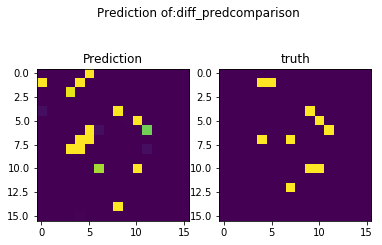

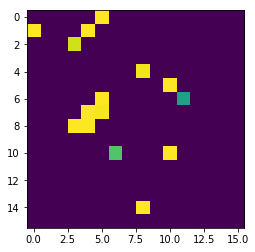

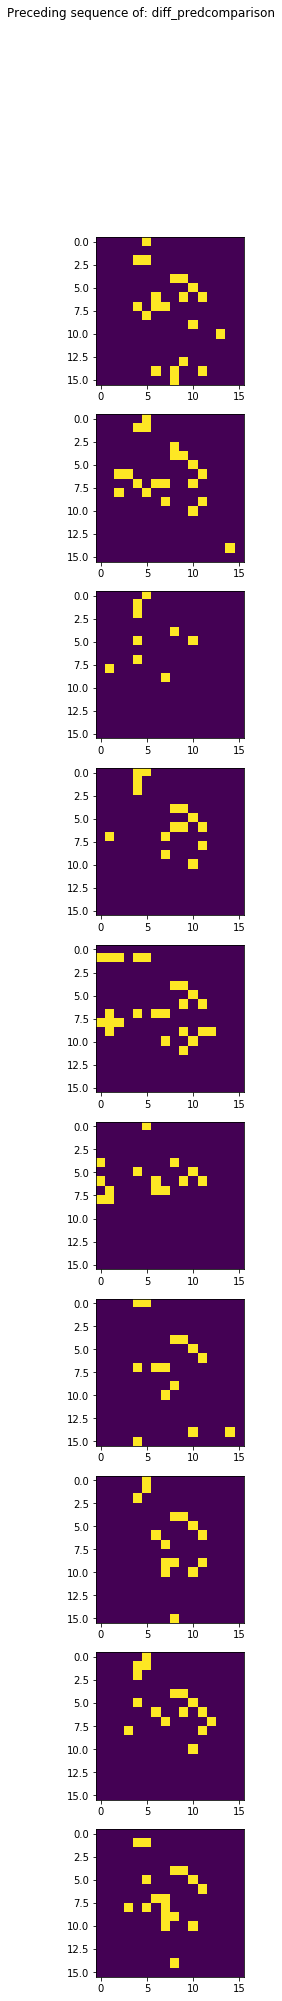

In [26]:
test_image_save(test_model, train_loader, name + "comparison", sample = 15, threshold = 0)


In [0]:

def f1(model, train_loader, avg = 'macro'):
    model.eval()
    # calculate x and prediction 
    for a, b in train_loader:
        # a in input, b is truth
        break # train loader cannot be indexed
        
        
    with torch.no_grad():
        x = model(a.cuda())
    
    
    x = x.cpu()
    x[x>0] = 1
    x[0>x] = 0
#     print(x[0][0][0])
    print(x[222,0,0].shape)
    print(b[222].shape)
#     print(b)
    print(b[222].view(-1, 256).numpy().shape)
    truth = set(list(b[222].view(256).numpy()))
    pred = set(list(x[222,0,0].view(256).numpy()))
    print(truth - pred)
    scores = []
    for i in range(len(b)):
        score = f1_score(b[i].view(256).numpy(), x[i,0,0].view(256).numpy(), average=avg)
        scores.append(score)
        truth = set(list(b[i].view(256).numpy()))
        pred = set(list(x[i,0,0].view(256).numpy()))
        if len(truth - pred) > 0:
            print(i)
#     score = f1_score(b[222].numpy(), b[222].numpy(), average=avg)
    return scores
#     print(score)
    
    
    
    
    
#     print(x[sample][0][0])
    
    

In [0]:
def metrics(model, train_loader, name = 'default', verbose = True, save = True, threshold = 0.4):
    """Calculate TN, FN, TP, FP for multilabel classification"""
    model.eval()
    sig = nn.Sigmoid()
    # calculate x and prediction 
    for a, b in train_loader:
        # a in input, b is truth
        break # train loader cannot be indexed
        
        
    with torch.no_grad():
        x = model(a.cuda())
    
    
    x = x.cpu()
    x = sig(x)
    
    x[x>threshold] = 1
    x[threshold>x] = 0
    
    # reshape
    truth = b.view(-1,256).numpy()
    pred = x[:,0,0].view(-1,256).numpy()
    tn = 0
    tp = 0
    fn = 0 
    fp = 0
    
    print(truth.shape)
    print(pred.shape)
    for i in range(len(b)):
        for j in range(256):
            # true positive
            if (truth[i][j] == 1) and (pred[i][j] == 1):
                tp += 1
            # true negative
            if (truth[i][j] == 0) and (pred[i][j] == 0):
                tn += 1
            
            #false positive
            if (truth[i][j] == 0) and (pred[i][j] == 1):
                fp +=1
            #false negative
            if (truth[i][j] == 1) and (pred[i][j] == 0):
                fn += 1

    prec = tp / (tp + fp)
    rec = tp/ (tp + fn)
    
    f_1 = 2 * prec * rec / (prec + rec)                
                
    if verbose:
        print("tn:" ,tn)
        print("tp:" , tp)
        print("fn:" , fn)
        print("fp" ,fp)
        print("prec:" ,prec)
        print("rec:" , rec)
        print("f1: ", f_1)
    
    if save:
        f = open(name + "metrics.csv", 'w')
        for i in [tn, tp, fn, fp, prec, rec, f_1]:
        
            f.write(str(i) + "\n")

        f.close()
    
                
            
    
    

In [0]:
def area_under_curve_metrics(model, train_loader, name = 'default', verbose = True, save = True):
    sig = nn.Sigmoid()
    model.eval()
    # calculate x and prediction 
    for a, b in train_loader:
        # a in input, b is truth
        break # train loader cannot be indexed
        
        
    with torch.no_grad():
        x = model(a.cuda())
        
    x = x.cpu()
    truth = b.view(-1,256).numpy()
    pred = sig(x[:,0,0].view(-1,256)).numpy()
#     truth = b.contiguous().view(-1).numpy()
#     pred = sig(x[:,0,0].contiguous().view(-1)).numpy()
#     fpr, tpr, thresholds = roc_curve(truth, pred)
#     plt.plot(fpr, tpr)
#     plt.plot(fpr, fpr)
    r = roc_auc_score(truth, pred)
    av = average_precision_score(truth, pred)
    if verbose:
        print(r)
        print(av)
    
    if save:
        f = open(name + "metrics.csv", 'a')
        for i in [r,av]:
        
            f.write(str(i) + "\n")

        f.close()
    
        
        
    


In [0]:
def brier_score(model, train_loader, name = 'default', verbose = True, save = True):
    model.eval()
    # calculate x and prediction 
    for a, b in train_loader:
        # a in input, b is truth
        break # train loader cannot be indexed
        
        
    with torch.no_grad():
        x = model(a.cuda())
    
    
    x = x.cpu()
    x[x>0] = 1
    x[0>x] = 0
    
    diff = (x[:,0,0] - b)**2
    brier = np.average(diff)
    
    if verbose:
        print(brier)
        
    if save:
        f = open(name + "metrics.csv", 'a')
        f.write(str(brier) + "\n")
        f.close()
        
        

In [0]:
def full_metrics(model, train_loader, name = 'default'):
    metrics(model, train_loader, name = name)
    area_under_curve_metrics(model, train_loader, name = name)
    brier_score(model, train_loader, name = name)
    
    
    

In [32]:


full_metrics(test_model, train_loader, name)

FINISHING ONE PASS
(4000, 256)
(4000, 256)
tn: 966927
tp: 12854
fn: 23728
fp 20491
prec: 0.38548508022192235
rec: 0.35137499316603793
f1:  0.36764053941968056
FINISHING ONE PASS
0.8718167578171323
0.3229042108182206
FINISHING ONE PASS
0.042546875


In [0]:
def curves(model, train_loader, name):
#     dataframe = pd.dataframe()
    sig = nn.Sigmoid()
    model.eval()
    # calculate x and prediction 
    for a, b in train_loader:
        # a in input, b is truth
        break # train loader cannot be indexed
        
        
    with torch.no_grad():
        x = model(a.cuda())
        
    x = x.cpu()
    truth = b.view(-1,256).numpy()
    pred = sig(x[:,0,0].view(-1,256)).numpy()
    fig, ax = plt.subplots(figsize=(6,6))
#     for i in range(16):
    leg = []
    
    colormap = plt.cm.nipy_spectral
    colors = [colormap(i) for i in np.linspace(0, 1,16)]
    ax.set_prop_cycle('color', colors)
    for j in range(16):
        leg.append((str(j) + "," + str(j)))
        t = b[:,j,j].contiguous().view(-1).numpy()
        p = sig(x[:,0,0,j,j].contiguous().view(-1)).numpy()
        fpr, tpr, thresholds = roc_curve(t, p)
        plt.plot(fpr, tpr)
    leg.append("Baseline")
    plt.plot(fpr, fpr)
    plt.title("ROC curves of diagonal labels. \n Predictors: hyd_population, distance to capital, sum precipitation")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Postitive Rate")
    plt.legend(leg)
    plt.xlim(0, 1)
    plt.ylim(0,1)
    
    plt.savefig(name + "roc_curve.pdf")
    plt.show()
    
    

FINISHING ONE PASS


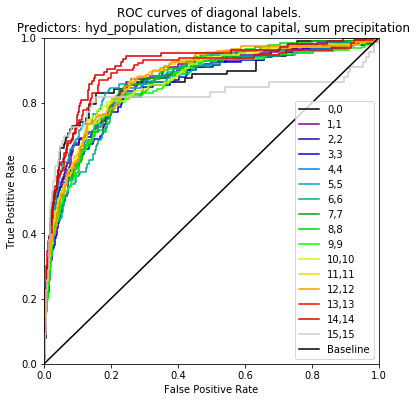

In [34]:
curves(test_model, train_loader, name)
# sns.set()
# x = [1,2,3]
# y = [4, 5,7]
# ax = sns.lineplot(x, y, palette= 'red')
# ax.plot([1,2], [11,22])

In [35]:
brier_score(test_model, train_loader)

FINISHING ONE PASS
0.042546875


In [36]:
    scores = f1(test_model, train_loader, avg = 'binary')
    np.save(name + "scores", scores)

FINISHING ONE PASS
torch.Size([16, 16])
torch.Size([16, 16])
(1, 256)
set()
167


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


515
810
1673
2584
3815


In [37]:
metrics(test_model, train_loader, name = name)

FINISHING ONE PASS
(4000, 256)
(4000, 256)
tn: 966927
tp: 12854
fn: 23728
fp 20491
prec: 0.38548508022192235
rec: 0.35137499316603793
f1:  0.36764053941968056


In [38]:
np.average(scores)

0.33233170032967907

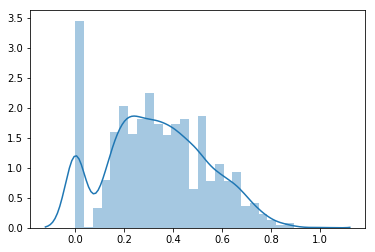

In [39]:
import seaborn as sns
plot = sns.distplot(scores)

In [40]:
plot.set_title("Histogram of average F1 Score per Image prediction")

Text(0.5, 1.0, 'Histogram of average F1 Score per Image prediction')

In [0]:
for a, b in train_loader:
    break

In [42]:
np.count_nonzero(b) / (2000)

18.291

# testing flipping the input direction


In [0]:
for d, b in train_loader:
    break
    

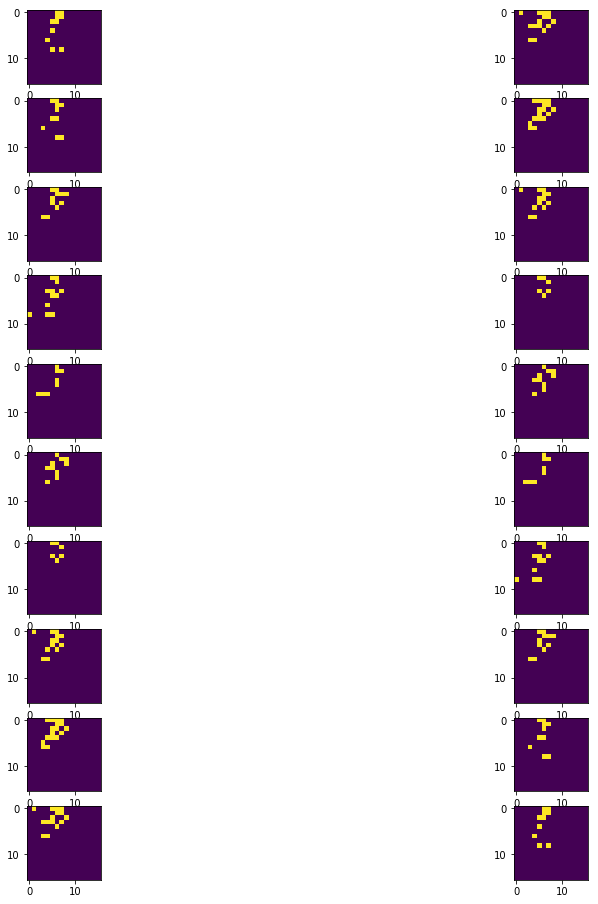

In [44]:
# set up some axes
a = d
a = a.numpy()
c = np.flip(a, 1)

# c = torch.flip(a, (0,1))
fig, axes = plt.subplots(10,2, figsize = (16,16))
#     print(x.shape)
#     print(b.shape)
#     axes[0].imshow(x[sample][0][0])
#     axes[1].imshow(b[sample])
    

for i in range(10):
    axes[i,0].imshow(a[0][i][0])
    axes[i,1].imshow(c[0][i][0])
    
plt.show()
    
    
    

In [45]:
c.shape
c = np.array(c)
torch.tensor(c)

tensor([[[[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           ...,
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],

          [[-8.3654e-03,  4.2698e-02, -8.3654e-03,  ..., -8.3654e-03,
            -8.3654e-03, -8.3654e-03],
           [-8.3654e-03, -8.3654e-03, -8.3654e-03,  ..., -8.3654e-03,
            -8.3654e-03, -8.3654e-03],
           [-8.3654e-03, -8.3654e-03, -8.3654e-03,  ..., -8.3654e-03,
            -8.3654e-03, -8.3654e-03],
 

In [46]:
e.shape

NameError: ignored

In [0]:
e = torch.tensor(c)



In [0]:
fig, axes = plt.subplots(10,2, figsize = (16,16))
#     print(x.shape)
#     print(b.shape)
#     axes[0].imshow(x[sample][0][0])
#     axes[1].imshow(b[sample])
    

for i in range(10):
    axes[i,0].imshow(a[0][i][0])
    axes[i,1].imshow(e.numpy()[0][i][0])
    
plt.show()
    
    

# after flipping


In [0]:
d = np.load("weights_bce.npy")
weights = torch.tensor(d) // 3
c = nn.BCEWithLogitsLoss(pos_weight=weights)

losses = batch_loss_histogram(test_model, train_loader, loss_func = c)


In [0]:
weights // 2

In [0]:
import seaborn as sns
sns.distplot(losses)

## making histograms to check kernel size effect 

In [0]:
# import seaborn as sns
d = np.load("weights_bce.npy")
weights = torch.tensor(d).to(device)
c = nn.BCEWithLogitsLoss(pos_weight=weights)

In [0]:
weights

In [0]:
for a,b in train_loader:
    break
    
    

In [0]:
a = a.to(device)
b = b.to(device)
c(a[0][0][0],b[0])

In [0]:
# b[0]
# sdaddasdasadad

In [0]:
# losses = batch_loss_histogram(test_model, train_loader)

In [0]:
# sns.distplot(losses)

In [0]:
# change in all - train_index  = list



# truth = train[:][1]
truth.shape


In [0]:
train.application_boolean



In [0]:
ans = train[0]


In [0]:
ans[0][0][0]

In [0]:
ans[1]
plt.imshow(ans[1])

In [0]:
t = truth.numpy()

In [0]:
t.shape


In [0]:
t[t>0] = 1
t[t<0] = 0

In [0]:
t[0]

In [0]:
incident_map = np.sum(t, axis = 0)

In [0]:
heatmap = sns.heatmap(incident_map).set_title("Total Number of UCDP Events in Training Set of 46898")

In [0]:
pyplot_fig = heatmap.get_figure()
pyplot_fig.savefig("heatmap_min_event_25_occurances.pdf")

In [0]:
multiplicative_factors = (46898  - incident_map)// incident_map




In [0]:
multiplicative_factors

In [0]:
np.save("weights_bce", multiplicative_factors)

In [0]:
second_heatmap = sns.heatmap(multiplicative_factors)
pyplot_fig = second_heatmap.get_figure()
pyplot_fig.savefig("multiplicative_factors_min_event_25_occurances.pdf")

# applying weight function to lossy dataset


In [0]:
weights = torch.tensor(multiplicative_factors)

In [0]:
loss_func  = nn.BCEWithLogitsLoss(pos_weight= weights)
loss_default = nn.BCEWithLogitsLoss()



In [0]:
d = b[0]

In [0]:
d[1 > d] = -1

In [0]:
d

In [0]:
print(loss_func(a[0][-1][0],b[0]))
print(loss_default(a[0][-1][0], b[0]))

In [0]:
c = torch.ones_like(a[0][-1][0])
c *= -1

In [0]:
print(loss_func(c,b[0]))
print(loss_default(c, b[0]))

In [0]:
print(loss_func(d,b[0]))
print(loss_default(d, b[0]))

In [0]:
l1 = batch_loss_histogram(test_model, train_loader, loss_func)
l2 = batch_loss_histogram(test_model, train_loader, loss_default)


In [0]:
sns.distplot(l1)
plt.figure()
sns.distplot(l2)